<a href="https://colab.research.google.com/github/sraeisi/MachineLearning_Physics/blob/master/3/MLP_CNN_Example_Galaxy_ZooII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

from urllib.request import urlopen
from imageio import imread
import requests
import io
from time import time

import cv2 
import os, shutil


import warnings
warnings.filterwarnings('ignore')

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

%load_ext tensorboard


gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus)>0:
    tf.config.experimental.set_memory_growth(gpus[0] , True)
    print('Running on GPU ...')
else:
    print('Running on CPU ...')



Running on GPU ...


In [2]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor="val_loss"),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5', 
                                       monitor='val_acc',
                                       mode='max',
                                       save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir=f'logs', update_freq=100),
]

In [3]:
batch_size = 128
n_w = 200
n_h = 200
n_c = 1
n_classes = 3 # This is only for the first question. 

# The number of steps in each epoch
stp_epch =100#  int(61578/ batch_size)+1
stp_epch

100

# Data: Galaxy Zoo

The data here is take from the Galaxy Zoo II survey. For detailed information, see

https://arxiv.org/pdf/1308.3496.pdf

The labels are more involved. Here I simplified the classification problem in the sense that the labels here are only the answers to the first question in the survey, i.e. Is the galaxy simply smooth, and rounded, with no sign of a disk? 

answers: 

1. smooth, 

2. features or disk, 

3. star or artifact).

In [4]:
import io, requests, zipfile
import pandas as pd

url_x = "https://www.dropbox.com/s/optw30o55q6mxlw/Cropped%26resized_GS_100_10000_withlabels.npz?dl=1"
url_y = 'https://www.dropbox.com/s/ctjjap42qilhu9s/Y_1.csv?dl=1'

### This file contains classes and the ids. 
s=requests.get(url_y, stream=True).content
df = pd.read_csv(io.BytesIO(s), index_col=0) 

# ### This file contains images and the ids. 
s=requests.get(url_x, stream=True).content
d = np.load(io.BytesIO(s))

# path = 'C:\\Users\\sraeisi\\Documents\\Datasets\\Physics\\Galaxies\\Kaggle\\'

# d = np.load(path+'Cropped&resized_GS_100_10000_withlabels.npz')
# df = pd.read_csv(path+'Y_1.csv', index_col=0) 

X, ids = [d[f] for f in ['imgs','ids']]
ids = ids.astype('float')

### We can make the labels based on the ids in the X file.
Y = df.loc[ids].values
print(Y.shape)

(10000, 3)


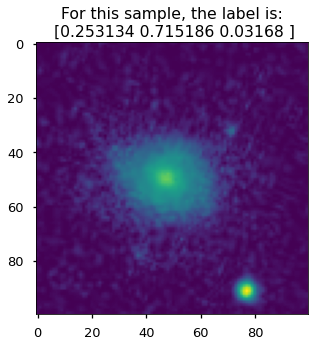

In [5]:
rand_ind = np.random.randint(0,len(Y) )

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1,1,1, title =f'For this sample, the label is:\n {Y[rand_ind]}' )
ax.imshow(X[rand_ind])
plt.show()

In [6]:
# For the data we have:
n_w, n_h = X[0].shape
n_f = n_w*n_h
n_c = 1 # number of channles
n_out= 3

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=0, test_size=.25 )


# To one hot
# from tensorflow.keras import utils
# Y_train = utils.to_categorical(Y_train, n_out)
# Y_test = utils.to_categorical(Y_test, n_out)

## To classes
# Y_train = Y_train.argmax(axis=1)
# Y_test = Y_test.argmax(axis=1)


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Let's start with a non-conv net

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import regularizers


model = models.Sequential()

model.add(layers.Flatten(input_shape=(n_w , n_h) ))

model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.Dropout(.1))

model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1280128   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 1,280,515
Trainable params: 1,280,515
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train,Y_train, 
                    epochs=50, batch_size = 64, 
                    verbose=0 , 
                    callbacks=my_callbacks, 
                    validation_data = (X_test, Y_test))

In [ ]:
### If on colab, you can run this to get the tensorboard 
%tensorboard --logdir 'logs_{model.name}'

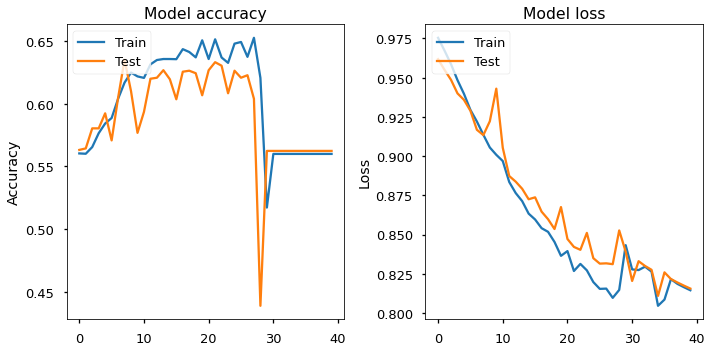

In [ ]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

***Question:*** What does these plot tell you? How can you improve this model?

It took 1 min 40 sec to train this model and the acc on the test set is less .7 . 

## Simple conv net

In [ ]:
# The convolutional layer expects an index for the number of channels, 
# So we need ot reshape the input. 
# The one at the end indicates the channel. 
# in this case, there is only one channel. 

X_train = X_train.reshape(-1, n_w, n_h, 1)
X_test = X_test.reshape(-1, n_w, n_h, 1)

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(n_w , n_h, 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(n_out, activation='softmax'))


model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

In [ ]:
X_train.shape

(7500, 100, 100, 1)

In [ ]:
history = model.fit(X_train,Y_train, 
                    epochs=40, batch_size = 256, 
                    verbose=0 , 
                    callbacks=my_callbacks, 
                    validation_data = (X_test, Y_test))

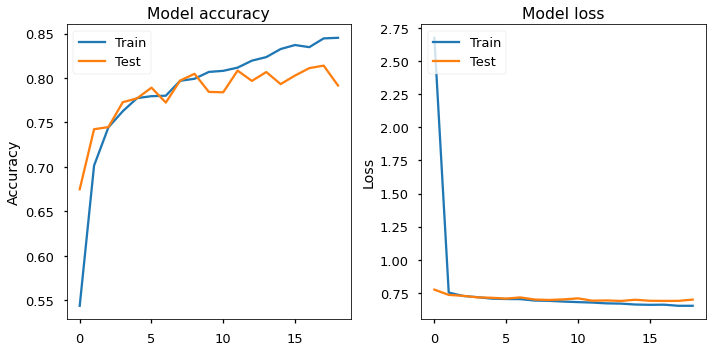

In [ ]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

## Convnet based on some of the famous designs

Look at the link here for a visual introduction to the differnt networks for computer vision applications.

https://arxiv.org/ftp/arxiv/papers/1901/1901.06032.pdf

https://microscope.openai.com/models

https://dataconomy.com/2017/04/history-neural-networks/

![alt text](https://cdn-images-1.medium.com/max/800/1*kBpEOy4fzLiFxRLjpxAX6A.png)



In [8]:
from tensorflow.keras.applications.vgg16 import preprocess_input

In [9]:
X_vgg16 = preprocess_input(X)
X_vgg16.shape

(10000, 100, 100)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_vgg16.reshape(-1, n_w, n_h, 1 ),
                                                    Y, random_state=0, test_size=.25 )

In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

# create the base pre-trained model
model = VGG16(weights=None, include_top=True, 
              input_shape=(n_w, n_h,1),
              classes=3)
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      640       
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [12]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [13]:
X_train = X_train.reshape(-1, n_w, n_h, 1)
X_test = X_test.reshape(-1, n_w, n_h, 1)

# X_c_train = X_c_train.reshape(-1, n_w, n_h, 1)
# X_c_test = X_c_test.reshape(-1, n_w, n_h, 1)

In [ ]:
# model.optimizer = optimizers.Adam(learning_rate=.1)
history = model.fit(X_train,Y_train, 
                    epochs=10, batch_size = 128, 
                    validation_data = (X_test, Y_test), 
#                     callbacks=my_callbacks, 
                    verbose=1)

Epoch 1/10
59/59 [==============================] - 29s 471ms/step - loss: 0.8304 - accuracy: 0.5341 - val_loss: 0.7919 - val_accuracy: 0.5620
Epoch 2/10
59/59 [==============================] - 28s 480ms/step - loss: 0.7591 - accuracy: 0.6731 - val_loss: 0.7599 - val_accuracy: 0.6696
Epoch 3/10
59/59 [==============================] - 27s 458ms/step - loss: 0.7359 - accuracy: 0.7339 - val_loss: 0.7490 - val_accuracy: 0.7012
Epoch 4/10
59/59 [==============================] - 27s 467ms/step - loss: 0.7226 - accuracy: 0.7509 - val_loss: 0.7424 - val_accuracy: 0.7472
Epoch 5/10
59/59 [==============================] - 28s 472ms/step - loss: 0.7193 - accuracy: 0.7606 - val_loss: 0.7084 - val_accuracy: 0.7796
Epoch 6/10
59/59 [==============================] - 27s 466ms/step - loss: 0.7072 - accuracy: 0.7843 - val_loss: 0.7084 - val_accuracy: 0.7784
Epoch 7/10
59/59 [==============================] - 28s 468ms/step - loss: 0.7002 - accuracy: 0.7943 - val_loss: 0.6930 - val_accuracy: 0.8000

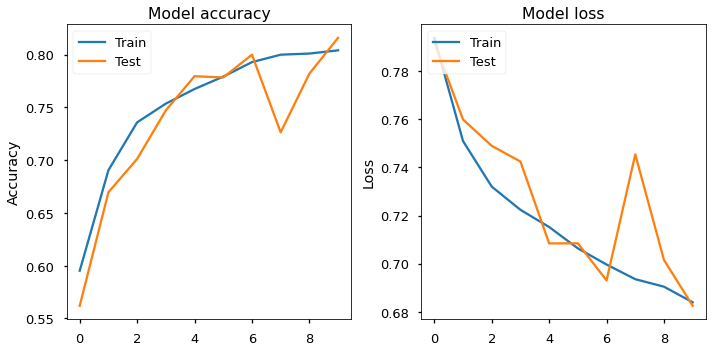

In [ ]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

# Transfer learning: Pre-trained Models

In [14]:
X = X.reshape(-1, n_w, n_h, n_c)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=0, test_size=.25 )
# X_c_train, X_c_test, Y_c_train, Y_c_test = train_test_split(X,Y_c, random_state=0, test_size=.25 )

In [15]:
# We need to format the data according to the inputs of VGG16

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16

X_3c = np.dstack([X]*3).reshape(-1, n_w, n_h, 3)
X_vgg16_3c = preprocess_input(X_3c)
Y_c = np.argmax(Y,axis=1)

train_datagen = ImageDataGenerator(rescale=1./255.,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True, 
                                   vertical_flip=True, 
                                   rotation_range=180, 
                                   validation_split=0.5)

train_generator = train_datagen.flow( X_vgg16_3c, Y_c, 
                                     batch_size=batch_size,
                                     shuffle=True, 
                                     subset='training')

validation_generator = train_datagen.flow( X_vgg16_3c, Y_c, 
                                     batch_size=batch_size,
                                     shuffle=True, 
                                     subset='validation')

## Pretrained VGG16 as a feature extractor

In [16]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, optimizers, losses

# create the base pre-trained model
vgg16_base = VGG16(weights='imagenet', include_top=False, 
              input_shape=(n_w, n_h,3), 
              )

vgg16_base.trainable = False
vgg16_base.trainable

58900480/58889256 [==============================] - 0s 0us/step


False

In [17]:
vgg16_base_out = vgg16_base.layers[-1].output_shape[1:]
n_features = np.prod(vgg16_base_out)
vgg16_base_out

(3, 3, 512)

In [18]:
'''
This function is to exctract features from the images. 
This is done based on VGG16 convnet. 
This function does the following

X, Y => f(X), Y

where f(x) is the feasures extracted from the images. 

'''

def extract_features(network, generator, sample_count):
    ## This is set based on the shape of the last layer of the VGG16
    features = np.zeros(shape=(sample_count, vgg16_base_out[0], vgg16_base_out[1], vgg16_base_out[2] ))
    labels = np.zeros(shape=(sample_count))

    i = 0
    for batch_x, batch_y in generator:
        batch_extfeaures = network.predict(batch_x)
#         print(batch_y.shape)
        features[i * batch_size : (i + 1) * batch_size] = batch_extfeaures
        labels[i * batch_size : (i + 1) * batch_size] = batch_y
        i += 1
#         print(i)
        if i * batch_size >= sample_count:
            break
    return features, labels

    

In [19]:
%%time 
train_features, train_labels = extract_features(vgg16_base, train_generator, 20*batch_size)
validation_features, validation_labels = extract_features(vgg16_base, validation_generator, 10*batch_size)

## The data needs to be flattened. 
train_features = np.reshape(train_features, (20*batch_size, n_features))
validation_features = np.reshape(validation_features, (10*batch_size, n_features ))

CPU times: user 27.9 s, sys: 1.04 s, total: 28.9 s
Wall time: 43.4 s


In [23]:
'''
Now let's make our new model.
'''
feature_based_model = models.Sequential()

feature_based_model.add(layers.Dense(256, activation='relu', input_dim=3 * 3 * 512))
# feature_based_model.add(layers.Dropout(0.5))

feature_based_model.add(layers.Dense(3, activation='softmax'))

feature_based_model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, 
             optimizer=tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True), 
             metrics=['accuracy'])

feature_based_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               1179904   
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 1,180,675
Trainable params: 1,180,675
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = feature_based_model.fit(train_features, train_labels, 
                                epochs=20, 
                                batch_size=batch_size, 
                                validation_data= (validation_features, validation_labels), 
#                                 callbacks=my_callbacks, 
                                verbose=1 )

Epoch 1/20
20/20 [==============================] - 1s 28ms/step - loss: 1.1017 - accuracy: 0.5055 - val_loss: 0.6943 - val_accuracy: 0.5695
Epoch 2/20
20/20 [==============================] - 0s 12ms/step - loss: 0.6920 - accuracy: 0.5637 - val_loss: 0.7015 - val_accuracy: 0.5695
Epoch 3/20
20/20 [==============================] - 0s 11ms/step - loss: 0.6762 - accuracy: 0.5898 - val_loss: 0.6484 - val_accuracy: 0.6391
Epoch 4/20
20/20 [==============================] - 0s 11ms/step - loss: 0.6682 - accuracy: 0.6195 - val_loss: 0.6587 - val_accuracy: 0.6117
Epoch 5/20
20/20 [==============================] - 0s 11ms/step - loss: 0.6330 - accuracy: 0.6621 - val_loss: 0.6117 - val_accuracy: 0.6789
Epoch 6/20
20/20 [==============================] - 0s 11ms/step - loss: 0.6061 - accuracy: 0.6879 - val_loss: 0.6402 - val_accuracy: 0.6359
Epoch 7/20
20/20 [==============================] - 0s 11ms/step - loss: 0.6375 - accuracy: 0.6637 - val_loss: 0.6397 - val_accuracy: 0.6047
Epoch 8/20
20

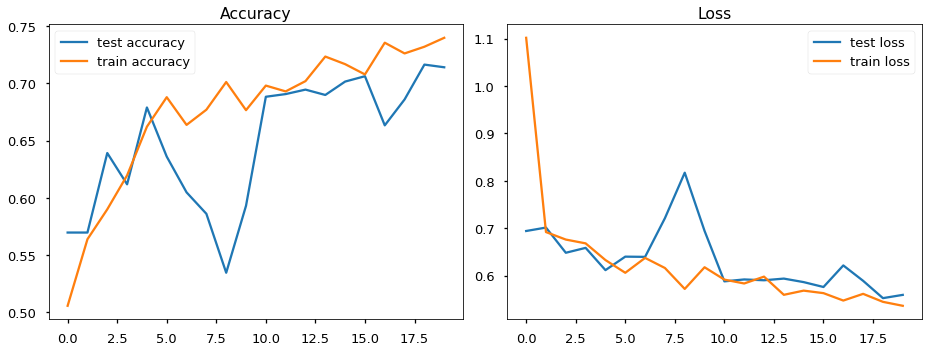

In [25]:
fig = plt.figure(figsize=(13, 5))
ax  = fig.add_subplot(1,2,1, title='Accuracy')
plt.plot(history.history['val_accuracy'], label = 'test accuracy')
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.legend(loc=0)

ax  = fig.add_subplot(1,2,2, title='Loss')
plt.plot(history.history['val_loss'], label = 'test loss')
plt.plot(history.history['loss'], label = 'train loss')
plt.legend(loc=0)

plt.tight_layout()
plt.show()


## Pretrained VGG16 + classifier at the end

In [26]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, optimizers, losses

# create the base pre-trained model
vgg16_base = VGG16(weights='imagenet', include_top=False, 
              input_shape=(n_w, n_h,3), 
              )

vgg16_base.trainable = False


In [27]:
'''
Now let's make our new model.
'''
pre_trained_model = models.Sequential()

pre_trained_model.add(vgg16_base)

pre_trained_model.add(layers.Flatten())

pre_trained_model.add(layers.Dense(256, activation='relu' ))
# pre_trained_model.add(layers.Dropout(0.5))

pre_trained_model.add(layers.Dense(3, activation='softmax'))

pre_trained_model.compile(loss=tf.keras.losses.mean_squared_error, 
             optimizer=tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True), 
             metrics=['accuracy'])

pre_trained_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               1179904   
                                                                 
 dense_5 (Dense)             (None, 3)                 771       
                                                                 
Total params: 15,895,363
Trainable params: 1,180,675
Non-trainable params: 14,714,688
_________________________________________________________________


In [37]:
model = models.Sequential()
model.add(vgg16_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
pre_trained_model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 4608)              0         
                                                                 
 dense_10 (Dense)            (None, 512)               2359808   
                                                                 
 dense_11 (Dense)            (None, 3)                 1539      
                                                                 
Total params: 17,076,035
Trainable params: 2,361,347
Non-trainable params: 14,714,688
_________________________________________________________________


In [29]:
print(vgg16_base.trainable)

False


In [30]:
train_generator[0][0].shape

(128, 100, 100, 3)

In [31]:
stp_epch

100

In [38]:
%%time
############### Training the model

history = pre_trained_model.fit(train_generator, 
                    validation_data  = validation_generator,
                    validation_steps = 5, 
#                     callbacks = my_callbacks, 
                    verbose = 1, 
                    epochs = 20)

Epoch 1/20
40/40 [==============================] - 21s 517ms/step - loss: 0.4110 - accuracy: 0.3390 - val_loss: 0.3065 - val_accuracy: 0.3906
Epoch 2/20
40/40 [==============================] - 19s 473ms/step - loss: 0.4157 - accuracy: 0.3446 - val_loss: 0.2915 - val_accuracy: 0.1359
Epoch 3/20
40/40 [==============================] - 20s 501ms/step - loss: 0.4129 - accuracy: 0.3226 - val_loss: 0.3056 - val_accuracy: 0.1063
Epoch 4/20
40/40 [==============================] - 19s 475ms/step - loss: 0.4098 - accuracy: 0.3628 - val_loss: 0.3008 - val_accuracy: 0.4391
Epoch 5/20
40/40 [==============================] - 19s 473ms/step - loss: 0.4147 - accuracy: 0.3560 - val_loss: 0.2931 - val_accuracy: 0.4578
Epoch 6/20
40/40 [==============================] - 20s 497ms/step - loss: 0.4171 - accuracy: 0.3562 - val_loss: 0.2926 - val_accuracy: 0.4547
Epoch 7/20
40/40 [==============================] - 20s 496ms/step - loss: 0.4155 - accuracy: 0.3274 - val_loss: 0.3082 - val_accuracy: 0.4094

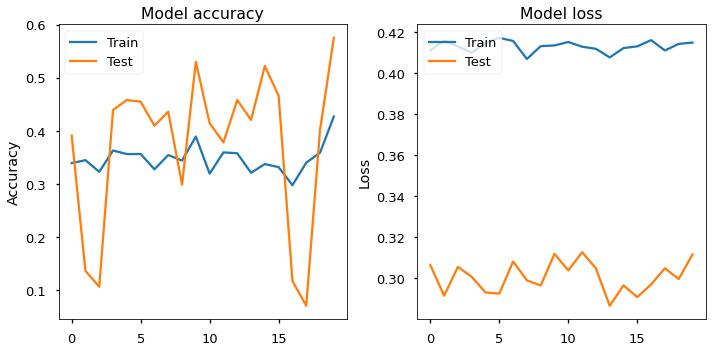

In [39]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

## Partially Freezed conv_base

In [ ]:
for layer in model.layers[:-1]:
    layer.trainable = False

for layer in model.layers:
    print(layer.name, layer.trainable  )

vgg16 False
flatten False
dense_20 False
dense_21 True


In [ ]:
vgg16_base.trainble = False

# We can freeze all bu the last two layers. 
for layer in vgg16_base.layers[-3:]:
    layer.trainable = True

## We can check which layers are traible. 
i=0    
for layer in vgg16_base.layers:
    i+=1
    print('Layer {} is trainable: {}'.format(i,layer.trainable)  )    

Layer 1 is trainable: False
Layer 2 is trainable: False
Layer 3 is trainable: False
Layer 4 is trainable: False
Layer 5 is trainable: False
Layer 6 is trainable: False
Layer 7 is trainable: False
Layer 8 is trainable: False
Layer 9 is trainable: False
Layer 10 is trainable: False
Layer 11 is trainable: False
Layer 12 is trainable: False
Layer 13 is trainable: False
Layer 14 is trainable: False
Layer 15 is trainable: False
Layer 16 is trainable: False
Layer 17 is trainable: True
Layer 18 is trainable: True
Layer 19 is trainable: True


In [41]:
pre_trained_model = models.Sequential()
pre_trained_model.add(vgg16_base)
pre_trained_model.add(layers.Flatten())
pre_trained_model.add(feature_based_model)

pre_trained_model.compile(loss=tf.keras.losses.mean_squared_error, 
             optimizer=tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True), 
             metrics=['accuracy'])


pre_trained_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 4608)              0         
                                                                 
 sequential_1 (Sequential)   (None, 3)                 1180675   
                                                                 
Total params: 15,895,363
Trainable params: 1,180,675
Non-trainable params: 14,714,688
_________________________________________________________________


In [49]:
y_prd.argmax(axis=1).shape

(128,)

In [52]:
# Even without training, this returns high accuracy. 
from tensorflow.keras.losses import mean_squared_error
from sklearn.metrics import accuracy_score

loss = 0
acc = 0
n_val =10

for i in range(n_val):
    d = validation_generator[i]
    y_prd = pre_trained_model.predict(d[0]).argmax(axis=1)

    loss += mean_squared_error(y_prd, d[1]).numpy().mean()/n_val
    acc += accuracy_score( y_prd,   d[1] )/n_val


print(f'The score before training is {acc}.')

The score before training is 0.7382812499999999.


In [ ]:
history = pre_trained_model.fit(train_generator, 
                    # steps_per_epoch  = stp_epch, 
                    validation_data  = validation_generator,
                    validation_steps = 5, 
                    callbacks = my_callbacks, 
                    verbose = 1, 
                    epochs = 5)

In [ ]:
##############Plotting the result
fig = plt.figure(figsize=(13, 5))
ax  = fig.add_subplot(1,2,1, title='Accuracy')
plt.plot(history.history['val_accuracy'], label = 'test accuracy')
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.legend(loc=0)

ax  = fig.add_subplot(1,2,2, title='Loss')
plt.plot(history.history['val_loss'], label = 'test loss')
plt.plot(history.history['loss'], label = 'train loss')
plt.legend(loc=0)

plt.tight_layout()
plt.show()


## Adding more trainable layers
Now we can unfreeze more layers and gradually fine tune the conv-base too. 

In [ ]:
vgg16_base.trainble = False

# We can freeze all bu the last two layers. 
for layer in vgg16_base.layers[-6:]:
    layer.trainable = True

## We can check which layers are traible. 
i=0    
for layer in vgg16_base.layers:
    i+=1
    print('Layer {} is trainable: {}'.format(i,layer.trainable)  )    

Layer 1 is trainable: False
Layer 2 is trainable: False
Layer 3 is trainable: False
Layer 4 is trainable: False
Layer 5 is trainable: False
Layer 6 is trainable: False
Layer 7 is trainable: False
Layer 8 is trainable: False
Layer 9 is trainable: False
Layer 10 is trainable: False
Layer 11 is trainable: False
Layer 12 is trainable: False
Layer 13 is trainable: False
Layer 14 is trainable: True
Layer 15 is trainable: True
Layer 16 is trainable: True
Layer 17 is trainable: True
Layer 18 is trainable: True
Layer 19 is trainable: True


In [ ]:
pre_trained_model = models.Sequential()
pre_trained_model.add(conv_base)
pre_trained_model.add(layers.Flatten())
pre_trained_model.add(feature_based_model)

pre_trained_model.compile(loss=tf.keras.losses.mean_squared_error, 
             optimizer=tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True), 
             metrics=['accuracy'])


# pre_trained_model.summary()

history = pre_trained_model.fit(train_generator, 
                    steps_per_epoch  = stp_epch, 
                    validation_data  = validation_generator,
                    validation_steps = 5, 
                    callbacks = my_callbacks, 
                    verbose = 1, 
                    epochs = 1)

In [ ]:
model.save('sample_model.h5')